<a href="https://colab.research.google.com/github/kenkaneki-Creator/skin-cancer-detection/blob/main/SkinCancerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import itertools
from sklearn.metrics import classification_report
from keras.applications import *
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from sklearn.utils import class_weight
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input as base_preprocess
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.applications.xception import preprocess_input as base_preprocess
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
tf.config.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth/(physical_devices[0], True)
except:
    pass

In [ ]:
#datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
dataset_path = '/content/drive/MyDrive/skin cancer detection'


In [ ]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications import MobileNetV2

In [ ]:
base_model=MobileNetV2(include_top=False, weights="imagenet", input_shape=(224,224,3))

In [ ]:
model=Sequential()
model.add(base_model)
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='sigmoid'))

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/skin cancer detection/HAM10000_metadata.csv")
data['image_full_name']=data['image_id']+'.jpg'
x=data[['image_full_name','dx','lesion_id']]
x.sample(10)


,image_full_name,dx,lesion_id
2280,ISIC_0030604.jpg,mel,HAM_0002613
3206,ISIC_0027426.jpg,nv,HAM_0004381
8756,ISIC_0026610.jpg,nv,HAM_0004279
7445,ISIC_0033650.jpg,nv,HAM_0001218
2775,ISIC_0032307.jpg,bcc,HAM_0001301
9998,ISIC_0033358.jpg,akiec,HAM_0004282
5602,ISIC_0026879.jpg,nv,HAM_0002393
429,ISIC_0029217.jpg,bkl,HAM_0002316
23,ISIC_0032128.jpg,bkl,HAM_0004884
7521,ISIC_0033729.jpg,nv,HAM_0000439


In [ ]:
from sklearn.model_selection import train_test_split
y=x.pop('dx').to_frame()
x_train, x_test, y_train, y_test= train_test_split(x,y,test_size=0.17, random_state=42)
x_train, x_val, y_train, y_val= train_test_split(x_train, y_train, test_size=0.17, random_state=42)


In [ ]:
train=pd.concat([x_train,y_train], axis=1)
val=pd.concat([x_val,y_val], axis=1)
test=pd.concat([x_test,y_test], axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
encoder.fit(y_train['dx'])
train['label'] = encoder.transform(train['dx'])
val['label'] = encoder.transform(val['dx'])
test['label'] = encoder.transform(test['dx'])
#encoder.fit(val['dx'])
#name_as_indexes_train=encoder.transform(val['dx'])
#val['label']=name_as_indexes_train

In [ ]:
#encoder=LabelEncoder()


#encoder.fit(test['dx'])
#name_as_indexes_test=encoder.transform(test['dx'])
#test['label']=name_as_indexes_test

In [ ]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.0,
    height_shift_range=0.00)

In [ ]:
val_test_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data = train_generator.flow_from_dataframe(dataframe=train,
                                                 batch_size=32,
                                                 directory='/content/drive/MyDrive/skin cancer detection/HAM10000_images_part_1',
                                                 x_col="image_full_name",
                                                 y_col="dx",
                                                 shuffle = True,
                                                 class_mode="categorical",
                                                 target_size=(224, 224))

Found 3452 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3446 invalid image filename(s) in x_col="image_full_name". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
test_generator=ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1, width_shift_range=0.0, height_shift_range=0.02)

In [ ]:
test_data = test_generator.flow_from_dataframe(dataframe=test,
                                                 batch_size=1,
                                                 directory='/content/drive/MyDrive/skin cancer detection/HAM10000_images_part_2',
                                                 x_col="image_full_name",
                                                 y_col="dx",
                                                 shuffle = False,
                                                 class_mode="categorical",
                                                 target_size=(224, 224))

Found 867 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 836 invalid image filename(s) in x_col="image_full_name". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# Check a batch to verify everything is working
x_batch, y_batch = next(train_data)
print("Shape of a batch of images:", x_batch.shape)  # Expected: (32, 224, 224, 3)
print("Shape of a batch of labels:", y_batch.shape)

Shape of a batch of images: (32, 224, 224, 3)
Shape of a batch of labels: (32, 7)


In [ ]:
val_data = test_generator.flow_from_dataframe(dataframe=val,
                                                 batch_size=64,
                                                 directory='/content/drive/MyDrive/skin cancer detection/HAM10000_images_part_2',
                                                 x_col="image_full_name",
                                                 y_col="dx",
                                                 shuffle = False,
                                                 class_mode="categorical",
                                                 target_size=(224, 224))

Found 702 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 712 invalid image filename(s) in x_col="image_full_name". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_control = ReduceLROnPlateau(monitor='val_acc', patience=3,
                                    verbose=1,factor=0.5, min_lr=0.0001)

In [ ]:
from keras.optimizers import Adam,SGD
sgd = SGD(learning_rate = 0.01, clipvalue = 0.5)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history=model.fit(train_data, steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data, verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=50, callbacks=[learning_control])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 2275s 20s/step - accuracy: 0.6139 - loss: 1.6312 - val_accuracy: 0.6500 - val_loss: 4.7021 - learning_rate: 0.0010
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


  1/107 ━━━━━━━━━━━━━━━━━━━━ 16:02 9s/step - accuracy: 0.7500 - loss: 0.7686

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


107/107 ━━━━━━━━━━━━━━━━━━━━ 83s 694ms/step - accuracy: 0.7500 - loss: 0.7686 - val_accuracy: 0.6613 - val_loss: 4.4070 - learning_rate: 0.0010
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 922s 9s/step - accuracy: 0.7271 - loss: 0.8196 - val_accuracy: 0.6500 - val_loss: 1.7888 - learning_rate: 0.0010
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7812 - loss: 0.7403 - val_accuracy: 0.6613 - val_loss: 1.7154 - learning_rate: 0.0010
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 914s 8s/step - accuracy: 0.7438 - loss: 0.7285 - val_accuracy: 0.6516 - val_loss: 5.7492 - learning_rate: 0.0010
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 293ms/step - accuracy: 0.7500 - loss: 0.8423 - val_accuracy: 0.6613 - val_loss: 6.5276 - learning_rate: 0.0010
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 924s 9s/step - accuracy: 0.7674 - loss: 0.6761 - val_accuracy: 0.6500 - val_loss: 6.3631 - learning_rate: 0.0010
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 37s 290ms/step - accuracy: 0.7500 - loss: 0.8290

In [ ]:
model.save('modelscd.h5')

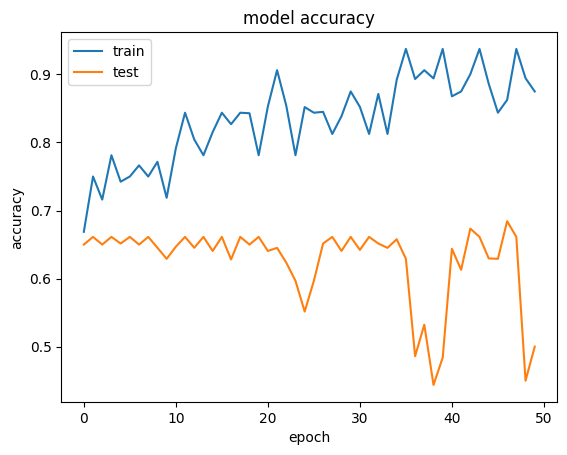

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

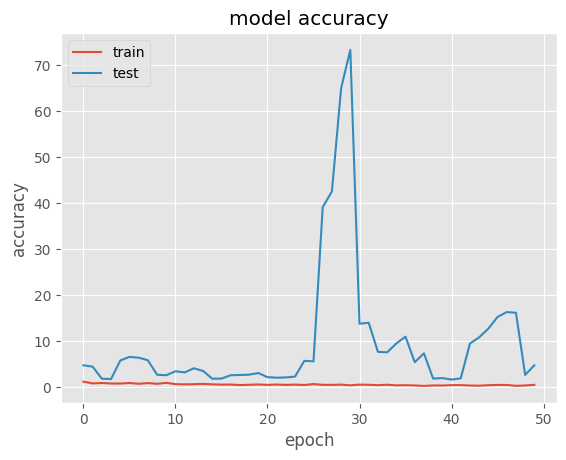

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

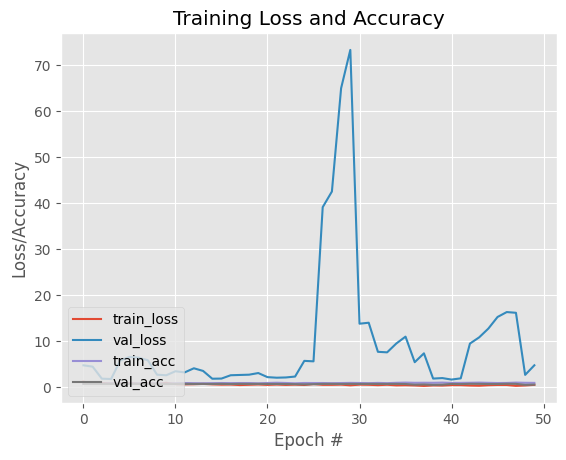

In [ ]:
  N = 50
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")


In [ ]:
test_data.reset()
predictions=model.predict(test_data,verbose=1,steps=test_data.samples//test_data.batch_size)
y_pred = np.argmax(predictions, axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


867/867 ━━━━━━━━━━━━━━━━━━━━ 659s 759ms/step


In [ ]:
print(len(y_pred), len(test['label']))

867 1703


In [ ]:
if len(y_pred) > len(test['label']):
    y_pred = y_pred[:len(test['label'])]
else:
    test_labels = test['label'][:len(y_pred)]

# Now both arrays have the same size
c = np.where(y_pred == test_labels)


In [ ]:
np.count_nonzero(c)

213

In [ ]:
print("test accuracy:",(np.count_nonzero(c)/len(test_labels))*100)

test accuracy: 78.6878945678


RESNET

In [ ]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# ensure results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)


[]


In [ ]:
pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"


In [ ]:
print(os.listdir('/kaggle/input/skin-cancer-mnist-ham10000'))


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/skin-cancer-mnist-ham10000'